In [6]:
""" Load Data Set """
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser="auto")
X, y = mnist["data"], mnist["target"]


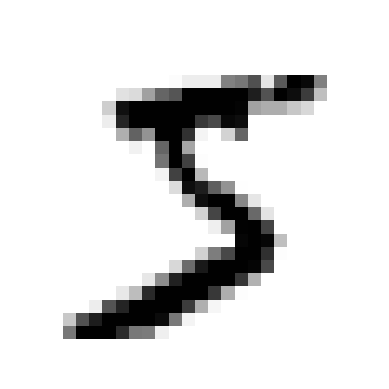

In [7]:
"""Plot out one example number"""
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


In [8]:
# Cast labels as integers
y = y.astype(np.uint8)

# Split into test and train set. Since this data set is already randomized, we can just take the last 10k rows for test.
X_train = np.array(X.iloc[:60000])
y_train = np.array(y.iloc[:60000])
X_test = np.array(X.iloc[60000:])
y_test = np.array(y.iloc[:60000:])


### Training a binary classifier
We will start by trying to classify if a number is == 5. 

In [9]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

#### Model Setup
We are going to use a Stochastic Gradient Descent (SGD) Model 

This classifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
#Predict a single test feature
sgd_clf.predict([some_digit])

array([ True])

#### Applying Cross Validation
Here we will write our own cross validation leveraging sklearns Stratified K-Fold Library

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # split the data
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    # Build and test the model
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)

    # Find correct results
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))


0.9669
0.91625
0.96785


We can also use built in sklearn cross_val_score

In [13]:
from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

#### Is this result good?

While it might appear so, let's try a model that always predicts that the value is 'Not-5'.


In [14]:
from sklearn.base import BaseEstimator

class NeverFiveClassifier(BaseEstimator):
    """An estimator that always predicts Not 5"""
    def fit(self, X: np.array, y: np.array = None) -> None:
        pass
    def predict(self, X: np.array) -> np.array:
        """Returns all false"""
        return np.zeros(shape=(len(X), 1), dtype=bool)
    
never_five_clf = NeverFiveClassifier()
cross_val_score(never_five_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.0997 , 0.0965 , 0.09995])


Unfortunately, the answer if is the original model is good is not really. One thing to keep in mind is the balance of this dataset. The never 5 classifier shows us that we would end up with an accuracy of ~90% (10% of the data is '5'). Therefore, accuracy may not be the best metric for this dataset. 

A better way to look at this data would be a confusion matrix, which highlights correctly and incorrectly predicted states.


In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_cross_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)


In [16]:
confusion_matrix(y_train_5, y_cross_pred)

array([[53892,   687],
       [ 1891,  3530]])

There are a few other metrics we can use to look at the results, the first being Precision:

$ Precision = {TP \over TP+FP} $

When it claims an image represents a 5, it is correct only Precision% of the time.

The second alternative metric to to consider is Recall:

$Recall = {TP \over TP+FN}$

Moreover, it only detects Recall% of the 5's.

You can also combine these two metrics into one, called the F-Score

$F-Score = {2 \over {1 \over Precision} + {1 \over Recall}} $ 

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Precision: {precision_score(y_train_5, y_cross_pred)}")
print(f"Recall: {recall_score(y_train_5, y_cross_pred)}")
print(f"F-Score: {f1_score(y_train_5, y_cross_pred)}")

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F-Score: 0.7325171197343846


While the F-Score can provide a balanced metric, it may not always be the the right choice. For instance, if you are building a model to detect cancer in a patient, it is okay to over classify people that as positive, but it is not acceptable to miss a patient that may have cancer (High Recall)

Or if designing a spam filter, it is okay if some spam gets through, but you want to make sure that the model does not send a real email to spam (High Precision).

### Precision vs Recall Tradeoff

Often times precision and recall oppose each other. 

In [18]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

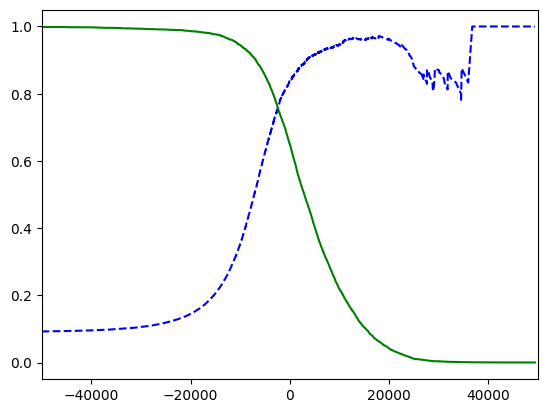

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlim(-50000,50000)


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)